# Preprocessing of CMIP models

This notebook should demonstrate how to use `pyremo` and the underlying [pyintorg](https://git.gerics.de/python/pyintorg) package to preprocess global model data from CMIP models that comply to CF conventions. The workflow is basically the same as before but is reimplmented in python for better integration into the workflow and for more flexibility of in and ouput data. This notebook basically show how to use the [remap](https://pyremo.readthedocs.io/en/latest/generated/pyremo.preproc.remap.html#pyremo.preproc.remap) API that understands CF conventions. The API takes and returns xarray datasets which has several advantages. For example, it will automatically vectorize computations along levels and time axes so we don't have to care about different calendars any more. Additionally, we can conserve important meta data from the input model and keep it in the forcing data, and consequently, in the REMO model ouput. Another critical advantage is the lazy computation which will allow dask to easiy parallelize the computation along the time axis and levels.

## Accessing CMIP input data

For this notebook, we take CMIP6 `MPI-ESM1-2-HR` model data directly from the DKRZ filesystem. However, the input is quite flexible and could come also from any other source the xarray accepts as input. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from dask_jobqueue import SLURMCluster
import dask
import xarray as xr
from dask.distributed import Client

import pyremo as pr

#dask.config.set(**{"array.slicing.split_large_chunks": False})

We will create a dask client here to make efficient use of the DKRZ node resources. In this example, we run the noteook on a `shared` node at DKRZ.

In [3]:
client = Client(dashboard_address="localhost:8787")

2025-03-28 09:43:57,628 - distributed.scheduler - WARNING - Failed to format dashboard link, unknown value: 'JUPYTERHUB_SERVICE_PREFIX'


In [4]:
from glob import glob

ta_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ta/gn/v20190710/ta_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
ps_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ps/gn/v20190710/ps_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197501010600-198001010000.nc"
hus_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/hus/gn/v20190710/hus_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
ua_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ua/gn/v20190815/ua_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
va_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/va/gn/v20190815/va_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
orog_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/fx/orog/gn/v20190710/orog_fx_MPI-ESM1-2-HR_historical_r1i1p1f1_gn.nc"
sftlf_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/fx/sftlf/gn/v20190710/sftlf_fx_MPI-ESM1-2-HR_historical_r1i1p1f1_gn.nc"
# tos_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Oday/tos/gn/v20190710/tos_Oday_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19750101-19791231.nc"
tos_files = glob(
    "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Oday/tos/gn/v20190710/*"
)
tos_files.sort()

datasets = {
    "ta": ta_file,
    "ps": ps_file,
    "hus": hus_file,
    "ua": ua_file,
    "va": va_file,
    "orog": orog_file,
    "sftlf": sftlf_file,
}

Now, we define a slightly optimized access function that works well at the DKRZ filesystem. Since we have a quite large input dataset, we want to access it lazily.

In [5]:
def open_mfdataset(
    files,
    use_cftime=True,
    parallel=True,
    data_vars="minimal",
    chunks={"time": 1},
    coords="minimal",
    compat="override",
    drop=None,
    **kwargs,
):
    """optimized function for opening CMIP6 6hrLev 3d datasets

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115

    """

    def drop_all_coords(ds):
        # ds = ds.drop(drop)
        return ds.reset_coords(drop=True)

    ds = xr.open_mfdataset(
        files,
        parallel=parallel,
        decode_times=False,
        combine="by_coords",
        preprocess=drop_all_coords,
        decode_cf=False,
        chunks=chunks,
        data_vars=data_vars,
        coords="minimal",
        compat="override",
        use_cftime=use_cftime,
        **kwargs,
    )
    return xr.decode_cf(ds, use_cftime=use_cftime)

The dataset for the SST is optional. In this example, we use the SST also from `MPI-ESM1-2-HR`. The SST for CMIP usually has a daily resolution and also probably a different grid.

In [6]:
# ref_ds = open_mfdataset(ta_file)
tos_ds = open_mfdataset(tos_files)

## Creating the global dataset

With the input data at hand, we can now create a global dataset that contains all neccessary input data for the dynamic preprocessing. We use the [gfile](https://pyremo.readthedocs.io/en/latest/generated/pyremo.preproc.gfile.html#pyremo.preproc.gfile) function here that will automatically check the input data and convert units if neccessary. If the SST dataset is given, it will also resample and regrid the SST to the atmospheric grid and a 6 hourly temporal resolution. In this example, we will only preprocess one month (`1979-01`).

In [7]:
from pyremo import preproc

gfile = preproc.get_gcm_dataset(
    datasets,
    tos=tos_ds.tos,
    time_range=slice("1979-01-01T06:00:00", "1979-02-01T00:00:00"), # choose a common time range from all files
)

inverting vertical axis
inverting vertical axis
inverting vertical axis
inverting vertical axis
using ap_bnds for akgm
using b_bnds for bkgm
inverting vertical coordinates


/work/ch0636/g300046/conda_envs/pyremo/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


converting sftlf units to fractional
converting tos units to K
converting orography to geopotential


The `gfile` dataset is comprable to the gfiles that were explictly created in the old preprocessing workflow. But here we don't have to store this dataset on disk but simply create it directly from the CMIP input lazily. However, we could also still read in the gfile dataset from older gfiles on the filesystem that were created in a different way. The preprocessing workflow does not depend on where the data comes from, it only depends on the gfile dataset having the right conventions concerning units and variable names. In addition, the gfile function also adds vertical coordinates and static variables, e.g., `orog` and `sftlf` to the dataset. Let's have a look:

In [8]:
gfile

<xarray.Dataset>
Dimensions:  (time: 124, lev: 95, lat: 192, lon: 384, lev_vertices: 96)
Coordinates:
  * time     (time) object 1979-01-01 06:00:00 ... 1979-02-01 00:00:00
  * lev      (lev) float64 9.816e-06 2.31e-05 3.079e-05 ... 0.959 0.9826 0.9961
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Dimensions without coordinates: lev_vertices
Data variables:
    ta       (time, lev, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    ps       (time, lat, lon) float32 dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    hus      (time, lev, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    ua       (time, lev, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    va       (time, lev, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    orog     (lat, lon) float32 dask.array<chunksize=(192, 384), meta=np.ndarray>
    sftlf    (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    akgm     (lev_vertices) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    bkgm     (lev_vertices) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mask     (lat, lon) bool dask.array<chunksize=(192, 384), meta=np.ndarray>
    tos      (time, lat, lon) float32 dask.array<chunksize=(124, 192, 384), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/e7cf2db1-51d1-4692-a1ff-60e2d204b533

## Target grid information

Now, we need to collect some information about the target grid. Here, we choose the `EUR-11` grid directly from pyremo:

In [9]:
domain_info = pr.domain_info("EUR-11")
domain_info

{'domain_id': 'EUR-11',
 'region': 4,
 'domain': 'Europe high-res.',
 'nlon': 433,
 'nlat': 433,
 'll_lon': -28.925,
 'll_lat': -23.925,
 'dlon': 0.11,
 'dlat': 0.11,
 'pollon': -162.0,
 'pollat': 39.25,
 'ur_lon': None,
 'ur_lat': None}

The preprocessing also needs the orography (`FIB`) and land sea mask (`BLA`) for the REMO target grid. We take those from the surface library that can be accessed from a surface library dataset.

In [10]:
surflib = pr.data.surflib("EUR-11", crop=False).load()
surflib

<xarray.Dataset>
Dimensions:       (rlon: 435, rlat: 435)
Coordinates:
  * rlon          (rlon) float64 -29.04 -28.93 -28.82 ... 18.48 18.59 18.71
  * rlat          (rlat) float64 -24.04 -23.93 -23.82 ... 23.48 23.59 23.71
Data variables: (12/14)
    rotated_pole  int32 1
    FIB           (rlat, rlon) float32 295.7 286.6 278.2 ... 16.8 31.95 44.6
    BLA           (rlat, rlon) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 0.9855
    AZ0           (rlat, rlon) float32 0.005009 0.005004 ... 0.03324 0.03231
    ALB           (rlat, rlon) float32 0.4709 0.475 0.4726 ... 0.1388 0.1438
    VGRAT         (rlat, rlon) float32 0.0 0.0 0.0 0.0 ... 0.3305 0.3181 0.3064
    ...            ...
    FOREST        (rlat, rlon) float32 0.0 0.0 0.0 0.0 ... 0.02978 0.0625 0.045
    FAO           (rlat, rlon) float32 2.0 2.0 2.0 2.0 2.0 ... 6.0 4.0 4.0 4.0
    WSMX          (rlat, rlon) float32 0.1 0.1 0.1 0.1 ... 0.252 0.2313 0.2235
    BETA          (rlat, rlon) float32 0.01 0.01 0.01 ... 0.7407 0.4051 0.6344
    WMINLOK       (rlat, rlon) float32 0.1 0.1 0.1 0.1 ... 0.1613 0.1641 0.1613
    WMAXLOK       (rlat, rlon) float32 0.1 0.1 0.1 0.1 ... 0.5375 0.2623 0.2604
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jul 01 12:03:07 2020: cdo -f nc copy lib_EUR-11_frac li...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

For the vertical interpolation, we have to give the vertical coordinates table containing the hybrid sigma coefficients for the target grid (`ak` and `bk`).

In [11]:
vc = pr.vc.tables["vc_27lev"]
vc

,ak,bk
0,0.000000,0.000000
1,5000.000000,0.000000
2,10000.000000,0.000000
3,13600.000000,0.000000
4,14736.355469,0.020319
5,15689.207031,0.036975
6,16266.609375,0.059488
7,16465.003906,0.087895
8,16297.621094,0.122004
9,15791.597656,0.161441


## Creating the forcing dataset

With the `gfile` dataset and the target grid information, we can now create the forcing dataset. We can use the [remap](https://pyremo.readthedocs.io/en/latest/generated/pyremo.preproc.remap.html#pyremo.preproc.remap) function here that basically assembles the same workflow as the former Fortran source code. The function basically does all the horizontal and vertical interpolations as well as pressure corrections including height corrections etc... Please note, that the efficiency of the computation might depend on how we access the input data and, of course, on the length of the time axis in the gfile dataset. For a long time axis, the computation should be done lazily!

In [12]:
ads = pr.preproc.remap(gfile, domain_info, vc, surflib)

In [13]:
ads

<xarray.Dataset>
Dimensions:                     (time: 124, rlon: 433, rlat: 433, lev: 27,
                                 lev_i: 28)
Coordinates:
  * time                        (time) object 1979-01-01 06:00:00 ... 1979-02...
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.48 18.59
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.48 23.59
  * lev                         (lev) int64 1 2 3 4 5 6 7 ... 22 23 24 25 26 27
  * lev_i                       (lev_i) int64 1 2 3 4 5 6 ... 23 24 25 26 27 28
    lon                         (rlat, rlon) float64 -10.32 -10.23 ... 68.65
    lat                         (rlat, rlon) float64 21.28 21.32 ... 67.86 67.8
Data variables: (12/16)
    T                           (time, lev, rlat, rlon) float32 dask.array<chunksize=(1, 27, 433, 433), meta=np.ndarray>
    U                           (time, lev, rlat, rlon) float32 dask.array<chunksize=(1, 27, 433, 433), meta=np.ndarray>
    V                           (time, lev, rlat, rlon) float32 dask.array<chunksize=(1, 27, 433, 433), meta=np.ndarray>
    PS                          (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    RF                          (time, lev, rlat, rlon) float32 dask.array<chunksize=(1, 27, 433, 433), meta=np.ndarray>
    TSW                         (time, rlat, rlon) float32 dask.array<chunksize=(124, 433, 433), meta=np.ndarray>
    ...                          ...
    TSI                         (time, rlat, rlon) float32 dask.array<chunksize=(124, 433, 433), meta=np.ndarray>
    hyai                        (lev_i) float64 0.0 5e+03 1e+04 ... 0.0 0.0 0.0
    hybi                        (lev_i) float64 0.0 0.0 0.0 ... 0.973 0.9923 1.0
    hyam                        (lev) float64 2.5e+03 7.5e+03 ... 0.0 0.0
    hybm                        (lev) float64 0.0 0.0 0.0 ... 0.9826 0.9961
    rotated_latitude_longitude  int32 0
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/e7cf2db1-51d1-4692-a1ff-60e2d204b533
    CORDEX_domain:          EUR-11

The forcing dataset seems to look fine! Please note, that also all global attributes from the input gfile dataset are copied to the forcing dataset. To check, we will explicitly look at the first timestep.

In [14]:
%time ads_ = ads.isel(time=0).compute()
# progress(ads_)

/work/ch0636/g300046/conda_envs/pyremo/lib/python3.10/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 17.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 1.89 s, sys: 428 ms, total: 2.32 s
Wall time: 19.9 s


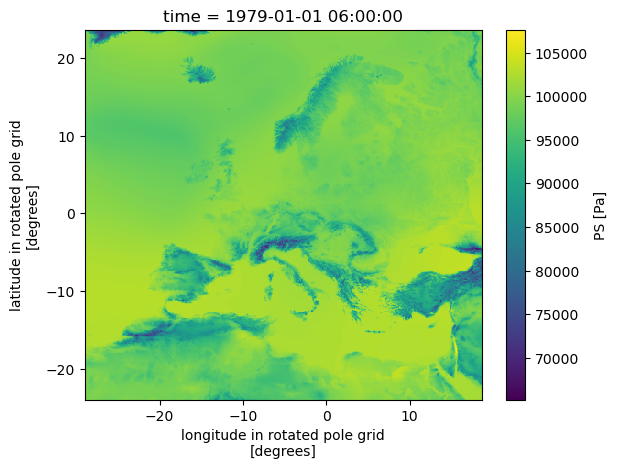

In [15]:
ads_.PS.plot()

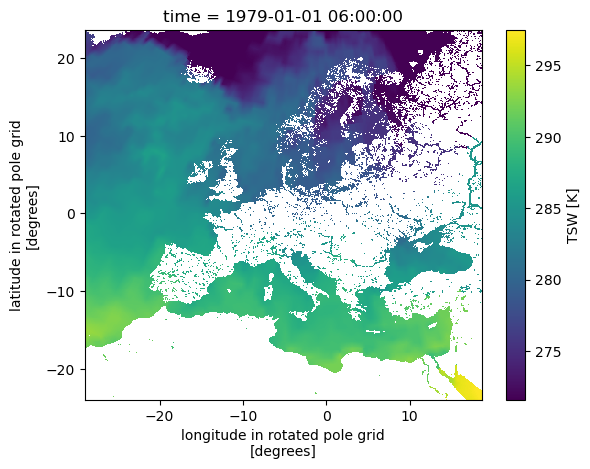

In [16]:
ads_.TSW.plot()

Note, that the whole `ads` forcing dataset has not been computed explicitly yet but only lazily. If we would trigger the whole computation, we might get in trouble to hold it in the memory. However, since we want a single file for each timestep on the disk anyway, we can start the computation only at this point, when we want to write it to disk. To organize the output, pyremo provides the [to_netcdf](https://pyremo.readthedocs.io/en/latest/generated/pyremo.preproc.to_netcdf.html) function that simply creates one NetCDF file per timestep and uses a REMO compliant naming convention. To start the computation and file writing, you can simply call

In [17]:
%time output = preproc.to_netcdf(ads, path='/scratch/g/g300046/xa')

/work/ch0636/g300046/conda_envs/pyremo/lib/python3.10/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 17.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 6min 12s, sys: 42.9 s, total: 6min 55s
Wall time: 37min 53s
